In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (16, 4)

pd.options.display.max_columns = 500

### Loading Data
For the purposes of this notebook walkthrough, imagine that there are 2 primary lists:
- **'titles':** the titles of the films in their rank order
- **'synopses':** the synopses of the films matched to the 'titles' order

There are other lists also like genres, imdb links of each titles to get additional information, however, we won't use them much in this walkthrough. We will be using synopses from 2 sources i.e. wiki & imdb.The data for titles and synopses is already parsed from the web for 100 movie titles. Our primary focus will be on the **'synopses'** list; 'titles' is mostly used for labeling purposes.

In [3]:
#import three lists: titles, links and wikipedia synopses
titles = open('datasets/title_list.txt').read().split('\n')

#ensures that only the first 100 are read in
titles = titles[:100]

print('First 5 titles: ')
print(titles[:5])

First 5 titles: 
['The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Raging Bull', 'Casablanca']


In [4]:
links = open('datasets/link_list_imdb.txt').read().split('\n')
links = links[:100]

print('First 5 imdb links of titles: ')
print(links[:5])

First 5 imdb links of titles: 
['http://www.imdb.com/title/tt0068646/', 'http://www.imdb.com/title/tt0111161/', 'http://www.imdb.com/title/tt0108052/', 'http://www.imdb.com/title/tt0081398/', 'http://www.imdb.com/title/tt0034583/']


In [5]:
synopses_wiki = open('datasets/synopses_list_wiki.txt', errors='ignore').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki

print('First 5 synopses from wiki of titles: ')
print(synopses_wiki[:5])

First 5 synopses from wiki of titles: 
[' Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter\'s wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito\'s youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito\'s godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter\'s wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito\'s youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at 

In [6]:
synopses_imdb = open('datasets/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

print('First 5 synopses from imdb of titles: ')
print(synopses_imdb[:5])

First 5 synopses from imdb of titles: 
['\n\nIn late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone\'s daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter\'s wedding day." One of the men who asks the Don for a favor is Amerigo Bonasera, a successful mortician and acquaintance of the Don, whose daughter was brutally beaten by two young men because she refused their advances; the men received minimal punishment. The Don is disappointed in Bonasera, who\'d avoided most contact with the Don due to Corleone\'s nefarious business dealings. The Don\'s wife is godmother to Bonasera\'s shamed daughter, a relationship the Don uses to extract new loyalty from the

In [7]:
genres = open('datasets/genres_list.txt').read().split('\n')
genres = genres[:100]

print('First 5 genres of titles: ')
print(genres[:5])

First 5 genres of titles: 
["[u' Crime', u' Drama']", "[u' Crime', u' Drama']", "[u' Biography', u' Drama', u' History']", "[u' Biography', u' Drama', u' Sport']", "[u' Drama', u' Romance', u' War']"]


In [8]:
print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses wiki')
print(str(len(synopses_imdb)) + ' synopses imdb')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses wiki
100 synopses imdb
100 genres


In [9]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

print(str(len(synopses)) + ' synopses wiki & imdb combined')

100 synopses wiki & imdb combined


In [10]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
movie_idx = []

for i in range(0,len(titles)):
    movie_idx.append(i)

### Applying Stopwords, Stemming and Tokenizing
This section is focused on defining some functions to manipulate the synopses. First, load NLTK's list of English stop words. Stop words are words like "a", "the", or "in" which don't convey significant meaning.

Next, import the **Snowball Stemmer** which is actually part of NLTK. Stemming is just the process of breaking a word down into its root.

In [11]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

Define two functions:
- tokenize_and_stem: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token
- tokenize_only: tokenizes the synopsis only

Both these functions are used to create a dictionary which becomes important in case we want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes.

In [12]:
# Define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [13]:
# Using stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies:
# one stemmed and one only tokenized.

totalvocab_stemmed = []
totalvocab_tokenized = []

for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [14]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('There are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
vocab_frame.head()

There are 312395 items in vocab_frame


,words
plot,plot
edit,edit
edit,edit
edit,edit
on,on


### TF-IDF and Document Similarity

- Define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the synopses list into a tf-idf matrix.
- To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.
- Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

Parameters for creating tf-idf matrix:
- max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
- min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. We are using 0.2; the term must be in at least 20% of the document.
- ngram_range: this just means I'll look at unigrams, bigrams and trigrams.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.2, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

# Get the Features names from Tf-idf matrix
feat_names = tfidf_vectorizer.get_feature_names()

print(tfidf_matrix.shape)

Wall time: 10 s
(100, 563)


- **dist** is defined as **1 - the cosine similarity** of each document.
- **Cosine Similarity** is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses).
- Subtracting it from 1 provides cosine distance which will be used for plotting on a euclidean (2-dimensional) plane.

Note that with dist it is possible to evaluate the similarity of any two or more synopses.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

### K-Means Clustering
- Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses.
- We will be using K-Means Cluster algorithm. K-means initializes with a pre-determined number of clusters (I chose 5).
- Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares.
- Next, the mean of the clustered observations is calculated and used as the new cluster centroid.
- hen, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.
- It took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima.

In [17]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

km

Wall time: 749 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Now, we can create a dictionary of titles, ranks, the synopsis, the cluster assignment, and the genre

In [18]:
films = { 'title': titles, 'movie_idx': movie_idx, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['movie_idx', 'title', 'cluster', 'genre'])

print(frame['cluster'].value_counts()) #number of films per cluster (clusters from 0 to 4)

grouped = frame['movie_idx'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

print(grouped.mean()) #average rank (1 to 100) per cluster

1    36
2    29
4    22
0     7
3     6
Name: cluster, dtype: int64
cluster
0    70.857143
1    50.500000
2    41.103448
3    52.833333
4    51.227273
Name: movie_idx, dtype: float64


Note that clusters 4 and 0 have the lowest rank, which indicates that they, on average, contain films that were ranked as "better" on the top 100 list.

Here is some fancy indexing and sorting on each cluster to identify which are the top n (I chose n=6) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster.

In [19]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1] #sort cluster centers by proximity to centroid
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[feat_names[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'captain', b'mr.', b'water', b'john', b'singing', b'attempt',

Cluster 0 titles: The Sound of Music, Jaws, The Green Mile, Nashville, The African Queen, Mutiny on the Bounty, A Clockwork Orange,

Cluster 1 words: b'car', b'police', b'killed', b'murders', b'apartments', b'train',

Cluster 1 titles: The Godfather, The Wizard of Oz, Titanic, Psycho, Sunset Blvd., Vertigo, On the Waterfront, West Side Story, Star Wars, E.T. the Extra-Terrestrial, The Silence of the Lambs, Chinatown, Some Like It Hot, 12 Angry Men, Unforgiven, Rocky, The Good, the Bad and the Ugly, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, The Apartment, High Noon, Goodfellas, The French Connection, It Happened One Night, Rain Man, Fargo, Close Encounters of the Third Kind, American Graffiti, Pulp Fiction, The Maltese Falcon, Taxi Driver, Double Indemnity, Rebel Without a Cause, Rear Window, The Third Man, North by Northwest,

Cluster 2 words: b'army', b'

In [20]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Movie_Idx'] = frame['movie_idx'] + 1
frame['Title'] = frame['title']

#export tables to HTML
print(frame[['Movie_Idx', 'Title']].loc[frame['cluster'] == 1].to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Movie_Idx</th>
      <th>Title</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>The Godfather</td>
    </tr>
    <tr>
      <td>9</td>
      <td>The Wizard of Oz</td>
    </tr>
    <tr>
      <td>10</td>
      <td>Titanic</td>
    </tr>
    <tr>
      <td>13</td>
      <td>Psycho</td>
    </tr>
    <tr>
      <td>14</td>
      <td>Sunset Blvd.</td>
    </tr>
    <tr>
      <td>15</td>
      <td>Vertigo</td>
    </tr>
    <tr>
      <td>16</td>
      <td>On the Waterfront</td>
    </tr>
    <tr>
      <td>19</td>
      <td>West Side Story</td>
    </tr>
    <tr>
      <td>20</td>
      <td>Star Wars</td>
    </tr>
    <tr>
      <td>21</td>
      <td>E.T. the Extra-Terrestrial</td>
    </tr>
    <tr>
      <td>23</td>
      <td>The Silence of the Lambs</td>
    </tr>
    <tr>
      <td>24</td>
      <td>Chinatown</td>
    </tr>
    <tr>
      <td>28</td>
      <td>Some Lik

### Multidimensional Scaling
Here is some code to convert the dist matrix into a 2-dimensional array using **multidimensional scaling.** I won't pretend I know a ton about MDS, but it was useful for this purpose. Another option would be to use principal component analysis.

In [21]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [22]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

### Visualizing Document Clusters
In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js).

First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [23]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

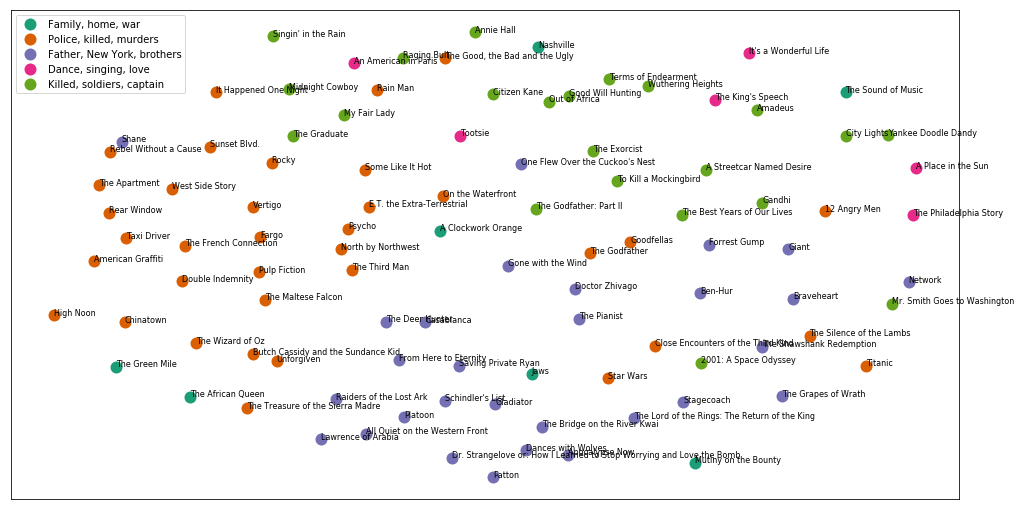

In [24]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom='off',       # ticks along the bottom edge are off
        top='off',          # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',          # changes apply to the y-axis
        which='both',       # both major and minor ticks are affected
        left='off',         # ticks along the bottom edge are off
        top='off',          # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)      #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [25]:
plt.close()